<a href="https://colab.research.google.com/github/jleandroforte/Desafio_Feature_Selection_Forte/blob/main/Desafio_Feature_Selection_Forte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Objetivos de la entrega**

En los desafíos previos evaluamos un modelo de regresión logística para predecir si una observación redunda en una venta o no.

Recordemos que una de nuestras variables, "order", toma el valor 1 cuando se trata de una venta y 0 caso contrario.

Vimos que un modelo simple y con una relativamente leve carga de Feature Engineering arrojaba un accuracy del 90%, lo cual habla de una estructura de datos adecuada para predecir ventas y más tarde, usando Forward Selection y ajustando los parámetros de la regresión, alcanzamos un accuracy total, prediciendo correctamente el valor que toma la variable order todas las observaciones del testing set.

En esta entrega tomamos un camino distinto para la ingeniería de features, en lugar de descansar en el método de forward selection, tomamos la siguiente ruta,

> Eliminamos variables co-lineales, para reducir la multicolinealidad. Esto no sólo nos ayuda cuando usamos una regresión logística, es necesario para cualquier modelo de regresión.

> Agrupamiento de productos: El dataset tiene más de 22 mil productos únicos, que se identifican por un valor numérico, pero ese valor numérico no es representativo de ninguna característica intrínseca de los productos, sólo su descripción. Esto puede generar resultados espurios en modelos de machine learning, por eso vamos a proponer una estrategia para agruparlos y reemplazarlos por variables dummy.

> Tratamiento de la estacionalidad: En entregas anteriores vimos como el revenue responde a un patrón estaciona, *al interior de cada período de 7 días*, esto es un insigth fundamental para reemplazar nuestros valores de la variable "Day", que también es numérica y cuenta los días de observaciones del 1 al 91, y por lo tanto puede complejizar innecesariamente la interpretabilidad de los datos de una regresión.

Finalmente, una vez evaluados estos métodos de Feature Engineering, vamos a estudiar si la aplicación de Principal-Component Analysis es una alternativa válida para obtener resultados óptimos en el modelo de regresión logística.


#**Breve Introducción a la base de datos**

El dataset con el que vamos a trabajar recopila datos de ventas y actividad de los clientes en el sitio web de una farmacia online a lo largo de 90 días.

Tenemos información sobre varias características de los productos que serán detalladas en secciones siguientes, sus precios, los precios de la competencia y comportamiento de los clientes, si hacen click en un producto, si los colocan en una canasta de productos y finalmente si compran un producto. Nótese que no todas las líneas representan ventas.

La clave del dataset es que la farmacia sigue una política de 'pricing dinámico' donde los precios de cada producto son ajustados diariamente, dentro de ciertas bandas.

#**Objetivos y estrategia de estimación**

En este trabajo vamos a enfocarnos en predecir si, dadas las características cada observación o fila del dataset, se va a producir una venta o no.

Recordemos que tenemos una variable llamada Order que toma valores 0 y 1, cuando order==1, la observación representa una venta, y cuando toma el valor 0 no se trata de una venta.

Siendo que nuestra variable dependiente es categórica y toma valores 0 (no-venta) y 1 (venta) vamos a proponer un modelo de regresión logística.

En otros trabajos el foco ha estado en predecir el revenue, y se ha demostrado en la segunda pre-entrega que el modelo de regresión lineal simple no es apropiado para nuestra estructura de datos, sólo como muestra, el r2 era de
~0.5.

Estimar la probabilidad de ventas, aparte de ser una pregunta de investigación importantísima en sí misma, puede funcionar como paso intermedio para estimar el revenue. Para ver por qué, recordemos que el revenue surge de las cantidades vendidas multiplicadas por el precio. El dataset contiene los precios, y la cantidad vendida en el set de testing se puede obtener construyendo una variable dividiendo revenue por precio, de modo que, si logramos predecir correctamente las ventas, podremos calcular el revenue.


In [ ]:
# Importamos las liberías necesarias.
from google.colab import drive
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression


drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Entregas/DB'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Entregas/DB


In [ ]:
# importamos los archivos y los combinamos en un solo dataset llamado 'farmacia' a través de la variable product id.

pricing_class=pd.read_csv("class.csv", sep='|')
pricing_items=pd.read_csv('items.csv', sep='|')
pricing_train=pd.read_csv('train.csv', sep='|')

dataset = pd.merge(pricing_train, pricing_items, on='pid');
farmacia=pd.DataFrame(dataset)

In [ ]:
farmacia

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
1,20746,2,6570,0,2,14.60,0,1,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
2,35477,2,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
3,61647,4,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
4,87130,5,6570,0,2,14.60,0,1,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2712203,91,20700,0,2,NaN,0,0,1,5.91,...,753,10OK0F,250,G,TEE,0,52,NaN,NaN,6.22
2755999,2713825,91,12000,0,2,NaN,1,0,0,13.01,...,811,20OHG,1,ST,BAN,0,53,NaN,NaN,13.70
2756000,2714766,91,10485,0,2,2.43,1,0,0,2.87,...,61,21OS1,60,G,TEE,0,52,1.0,NaN,3.03
2756001,2718999,91,15158,0,2,3.69,1,0,0,4.77,...,811,20OI2,1,ST,BAN,0,53,NaN,NaN,4.14


In [ ]:
farmacia.shape

(2756003, 21)

In [ ]:
farmacia.info

<bound method DataFrame.info of           lineID  day    pid  adFlag  availability  competitorPrice  click  \
0              1    1   6570       0             2            14.60      1   
1          20746    2   6570       0             2            14.60      0   
2          35477    2   6570       0             2            14.60      1   
3          61647    4   6570       0             2            14.60      1   
4          87130    5   6570       0             2            14.60      0   
...          ...  ...    ...     ...           ...              ...    ...   
2755998  2712203   91  20700       0             2              NaN      0   
2755999  2713825   91  12000       0             2              NaN      1   
2756000  2714766   91  10485       0             2             2.43      1   
2756001  2718999   91  15158       0             2             3.69      1   
2756002  2733652   92  12233       0             2            14.06      1   

         basket  order  price  ...  manufacturer   group content unit  \
0             0      0  16.89  ...           255    2FOI      50   ML   
1             1      0  16.89  ...           255    2FOI      50   ML   
2             0      0  16.89  ...           255    2FOI      50   ML   
3             0      0  16.89  ...           255    2FOI      50   ML   
4             1      0  16.89  ...           255    2FOI      50   ML   
...         ...    ...    ...  ...           ...     ...     ...  ...   
2755998       0      1   5.91  ...           753  10OK0F     250    G   
2755999       0      0  13.01  ...           811   20OHG       1   ST   
2756000       0      0   2.87  ...            61   21OS1      60    G   
2756001       0      0   4.77  ...           811   20OI2       1   ST   
2756002       0      0  16.69  ...            71    2FOI      50   ML   

        pharmForm genericProduct  salesIndex  category  campaignIndex    rrp  
0             TRO              0          40     193.0            NaN  18.25  
1             TRO              0          40     193.0            NaN  18.25  
2             TRO              0          40     193.0            NaN  18.25  
3             TRO              0          40     193.0            NaN  18.25  
4             TRO              0          40     193.0            NaN  18.25  
...           ...            ...         ...       ...            ...    ...  
2755998       TEE              0          52       NaN            NaN   6.22  
2755999       BAN              0          53       NaN            NaN  13.70  
2756000       TEE              0          52       1.0            NaN   3.03  
2756001       BAN              0          53       NaN            NaN   4.14  
2756002       TRO              0          40       NaN            NaN  17.04  

[2756003 rows x 21 columns]>

In [ ]:
farmacia.describe(include='all')

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
count,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.655316e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,...,2.756003e+06,2756003,2756003,2756003,2561879,2.756003e+06,2.756003e+06,2.668609e+06,468035,2.756003e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,533,548,8,278,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22OI3,50,ST,TAB,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,159787,380869,1332256,252906,NaN,NaN,NaN,251965,NaN
mean,1.378002e+06,4.992118e+01,1.044790e+04,3.177888e-01,1.111035e+00,1.277288e+01,5.743198e-01,1.698423e-01,2.558379e-01,1.385008e+01,...,1.744467e+02,NaN,NaN,NaN,NaN,1.055086e-01,4.624467e+01,1.154272e+02,NaN,1.830907e+01
std,7.955897e+05,2.529451e+01,6.456013e+03,4.656170e-01,3.921785e-01,1.275295e+01,4.944458e-01,3.754943e-01,4.363312e-01,1.362307e+01,...,1.873093e+02,NaN,NaN,NaN,NaN,3.072077e-01,6.422195e+00,9.368947e+01,NaN,1.866168e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,...,1.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,1.000000e+00,NaN,7.000000e-02
25%,6.890015e+05,3.100000e+01,4.313000e+03,0.000000e+00,1.000000e+00,5.480000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,...,5.600000e+01,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,4.600000e+01,NaN,7.980000e+00
50%,1.378002e+06,5.000000e+01,1.007700e+04,0.000000e+00,1.000000e+00,8.990000e+00,1.000000e+00,0.000000e+00,0.000000e+00,9.850000e+00,...,1.040000e+02,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,9.200000e+01,NaN,1.317000e+01
75%,2.067002e+06,7.100000e+01,1.614400e+04,1.000000e+00,1.000000e+00,1.506000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.645000e+01,...,2.200000e+02,NaN,NaN,NaN,NaN,0.000000e+00,5.300000e+01,1.520000e+02,NaN,2.195000e+01


In [ ]:
farmacia.dtypes

lineID               int64
day                  int64
pid                  int64
adFlag               int64
availability         int64
competitorPrice    float64
click                int64
basket               int64
order                int64
price              float64
revenue            float64
manufacturer         int64
group               object
content             object
unit                object
pharmForm           object
genericProduct       int64
salesIndex           int64
category           float64
campaignIndex       object
rrp                float64
dtype: object

#**Descripción de las variables:**

**Vamos a proceder a describir verbalmente nuestras variables, cuando se trate de variables que no varían en el tiempo, se explicita en la descripción**

**day**: el día que se registra, recordemos que tenemos datos 91 días de ventas y otras acciones de usuarios en el sitio web. El datatype es int.

**pid**: El id del producto, como vimos, tenemos más de 22 mil productos. El datatype es int, los productos se identifican por un numero, no por su nombre. Es una variable invariante.

**adFlag**: Nos indica si el producto en cuestión es objeto de una campaña publicitaria. El valor 1 indica que hubo capaña, y 0 indica que no la hubo.

**availability**: Status de disponibilidad de los productos, toma los valores {1,2,3,4}

**competitorPrice** : El precio de la competencia para un producto. Es un floating point.

**click, basket, order**: Denotan acciones de los usuarios, si hicieron click en un producto, si lo colocaron en un carrito de compra (pero no necesariamente lo compraron), mientras que order indica si efectivamente el registro denota una compra. Las 4 variables toman los valores {0,1}, donde 1 denota acción (compra, carrito de compra, click) y el 0 la ausencia de acción.

**price**: El precio efectivamente asociado a la observacion. Recordemos que la farmacia sigue una estrategia de 'pricing dinámico', los precios de cada producto se ajustan día a día. También es importante tener en cuenta que no se trata de precios customizados para clientes, los ajustes de precios son diarios y automáticos. Esto introduce una gran variabilidad en las observaciones que nos permitirá evaluar la influencia de los precios en las ventas, y es el insumo fundamental para predecir la demanda futura en función de como ajustemos nuestros precios. El precio es un floating point.

**revenue**: Los ingresos por ventas. Es decir, el precio multiplicado por las cantidades compradas (que no observamos, solo observamos precios, compras (la variable 'order') y revenue). El revenue es un floating point.

**manufacturer**: El fabricante de cada producto. Se identifica mediante un numero entero. Es invariante, al igual que el product id.

**group**: El grupo de productos, combina letras y numeros. Es invariante.

**content**: El contenido de un producto, se identifica bajo la nomenclatura numeroXnumero, por caso: 5X10. Es invariante.

**unit**: La unidad del producto, es un string de mayúsculas.Es invariante.

**pharmForm**: La dosis: son 3 letras mayúsculas. Es invariante.

**genericProduct**: Si se trata de un medicamento generico, toma los valores {0,1}, el 1 indica que se trata de un medicamento genérico. Es invariante.

**salesIndex**: un código de dispensión de medicamentos de Estados unidos. Es un entero. Es invariante.

**category**: categoría de negocio: es un numero de negocio. Es invariante.

**campaignIndex**: Tipo de campaña publicitaria de que fue objeto el producto, toma los valores {A,B,C}

**rrp**: El precio de referencia, recordemos que la farmacia ajusta los precios de cada producto diariamente, pero cada item tiene un precio de referencia, más adelante vamos a graficar algunos ejemplos. Es invariante, la variabilidad está en los precios efectivos.

#**Módulo de Limpieza de datos primaria**

##**Tratamiento de Missing Values**

En primer lugar, vemos cuantos datos nos faltan por columna, y proponemos las siguientes soluciones para aquellas variables donde identificamos missing values:

Para competitor price vamos a reemplazar los missing values por la mediana del precio por cada producto, no en general, en caso de no disponer de un precio para algún producto, se reemplaza por la mediana de la variable en el dataset completo.

para pharmForm, al menos por ahora, vamos a reemplazar por el valor más frecuente, a nivel de producto y no en el agregado. No se pueden usar medidas como media o mediana porque no es una variable numérica.

Para category usamos el mismo procedimiento que para pharmForm, con las mismas consideraciones.

Para campaing index, que en el dataset toma los valores {A,B,C}, e indica el tipo de campaña publicitaria que se llevó a cabo, tenemos 2 tipos de tratamiento, dado que es dependiente de adFlag, solo cuando adFlag es igual a 1 hay campaña publicitaria, de modo que si adFlag==0, reemplazamos por "D", que es una manera de indicar que no hay campaña publicitaria, mientras que para los casos en que adFlag==1 reemplazamos por la moda o valor más repetido a nivel de producto.

In [ ]:
datos_faltantes = farmacia.isnull().sum()
print("Datos faltantes por columna: " , datos_faltantes)

Datos faltantes por columna:  lineID                   0
day                      0
pid                      0
adFlag                   0
availability             0
competitorPrice     100687
click                    0
basket                   0
order                    0
price                    0
revenue                  0
manufacturer             0
group                    0
content                  0
unit                     0
pharmForm           194124
genericProduct           0
salesIndex               0
category             87394
campaignIndex      2287968
rrp                      0
dtype: int64


Reemplazo de missing values para la variable competitorPrice, si a nivel de producto no hay una mediana, se reemplaza por la mediana de la columna en general.

In [ ]:
medianas_faltantes = farmacia.groupby('pid')['competitorPrice'].transform('median') # recordemos que pid es 'Product Id', por eso hacemos el reemplazo a ese nivel.

farmacia['competitorPrice'] = farmacia['competitorPrice'].fillna(medianas_faltantes)

# En los casos no capturados por las lineas anteriores reemplazamos por la mediana general de la variable:
mediana_competitorPrice = farmacia['competitorPrice'].median()

farmacia['competitorPrice'] = farmacia['competitorPrice'].fillna(mediana_competitorPrice)

Reemplazo de missing values para las variables pharmForm y category, estamos usando el valor más frecuente, por eso la función hace referencia a la moda ("mode")

In [ ]:
def completar_pharmform(series):
    if series.mode().empty:
        return series
    else:
        moda_pharmForm = series.mode().iloc[0]
        return series.fillna(moda_pharmForm)

farmacia['pharmForm'] = farmacia.groupby('pid')['pharmForm'].transform(completar_pharmform)

farmacia['pharmForm'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.

In [ ]:
def completar_category(series):
    if series.mode().empty:
        return series
    else:
        moda_category = series.mode().iloc[0]
        return series.fillna(moda_category)

farmacia['category'] = farmacia.groupby('pid')['category'].transform(completar_category)

farmacia['category'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.



Reemplazo de missing values para campaignIndex, recordemos el metodo:
tenemos 2 tipos de tratamiento, dado que es dependiente de adFlag, solo cuando adFlag es igual a 1 hay campaña publicitaria, de modo que si adFlag==0, reemplazamos por "D" (ya que las campañas son {A,B,C}, y de esta forma con la "D" podemos identificar rápidamente que no hay campaña) para los casos en que adFlag==1 reemplazamos por la moda o valor más repetido a nivel de producto.  

In [ ]:
farmacia['campaignIndex'].fillna('D', inplace=True)

mask = (farmacia['adFlag'] == 1) & (farmacia['campaignIndex'].isna())
farmacia.loc[mask, 'campaignIndex'] = farmacia[mask].groupby('pid')['campaignIndex'].transform(lambda x: x.mode().iloc[0])

farmacia['campaignIndex'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.


Ahora constatamos que ya no tenemos más missing values:



In [ ]:
datos_faltantes = farmacia.isnull().sum()
print("Datos faltantes por columna: " , datos_faltantes)


Datos faltantes por columna:  lineID             0
day                0
pid                0
adFlag             0
availability       0
competitorPrice    0
click              0
basket             0
order              0
price              0
revenue            0
manufacturer       0
group              0
content            0
unit               0
pharmForm          0
genericProduct     0
salesIndex         0
category           0
campaignIndex      0
rrp                0
dtype: int64


##**Encoding de Variables Categoricas**

Repasemos nuestras variable categóricas y sus valores unicos para saber si son factibles de aplicar encoding.

In [ ]:
farmacia.describe(include='object')

,group,content,unit,pharmForm,category,campaignIndex
count,2756003,2756003,2756003,2756003,2756003.0,2756003
unique,533,548,8,279,410.0,4
top,22OI3,50,ST,TAB,50.0,D
freq,159787,380869,1332256,252906,118323.0,2287968


Como vemos, tenemos 6 variables que quedemos convertir a dummies para poder usar como variables explicativas de un modelo. Como se puede observar, algunas de las variables tienen varios cientos de valores únicos, lo cual consume la totalidad de la memoria de esta versión de Colab. Vamos a limitar el encoding a las variables unit y campaignIndex.

En el caso de la variable group, recordemos que se trata de agrupamientos de productos, para los cuales tenemos la variable pid (product ID), de modo que no estariamos perdiendo informacion al excluirla de un modelo, si incluimos el product id.


Para ello usamos el metodo get_dummies

In [ ]:
dummies = pd.DataFrame(pd.get_dummies(farmacia[['unit', 'campaignIndex']]))

In [ ]:
dummies.dtypes

unit_CM            uint8
unit_G             uint8
unit_KG            uint8
unit_L             uint8
unit_M             uint8
unit_ML            uint8
unit_P             uint8
unit_ST            uint8
campaignIndex_A    uint8
campaignIndex_B    uint8
campaignIndex_C    uint8
campaignIndex_D    uint8
dtype: object

In [ ]:
dummies

,unit_CM,unit_G,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,0,1,0,0,0,0,0,0,0,0,0,1
2755999,0,0,0,0,0,0,0,1,0,0,0,1
2756000,0,1,0,0,0,0,0,0,0,0,0,1
2756001,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
farmacia_final = pd.concat([farmacia, dummies], axis=1) #creamos un dataset que sea nuestras variables originales y las dummies.

In [ ]:
farmacia_final

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,0,0,0,1,0,0,0,0,0,1
1,20746,2,6570,0,2,14.60,0,1,0,16.89,...,0,0,0,1,0,0,0,0,0,1
2,35477,2,6570,0,2,14.60,1,0,0,16.89,...,0,0,0,1,0,0,0,0,0,1
3,61647,4,6570,0,2,14.60,1,0,0,16.89,...,0,0,0,1,0,0,0,0,0,1
4,87130,5,6570,0,2,14.60,0,1,0,16.89,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2712203,91,20700,0,2,8.99,0,0,1,5.91,...,0,0,0,0,0,0,0,0,0,1
2755999,2713825,91,12000,0,2,8.99,1,0,0,13.01,...,0,0,0,0,0,1,0,0,0,1
2756000,2714766,91,10485,0,2,2.43,1,0,0,2.87,...,0,0,0,0,0,0,0,0,0,1
2756001,2718999,91,15158,0,2,3.69,1,0,0,4.77,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
farmacia_final.dtypes

lineID               int64
day                  int64
pid                  int64
adFlag               int64
availability         int64
competitorPrice    float64
click                int64
basket               int64
order                int64
price              float64
revenue            float64
manufacturer         int64
group               object
content             object
unit                object
pharmForm           object
genericProduct       int64
salesIndex           int64
category            object
campaignIndex       object
rrp                float64
unit_CM              uint8
unit_G               uint8
unit_KG              uint8
unit_L               uint8
unit_M               uint8
unit_ML              uint8
unit_P               uint8
unit_ST              uint8
campaignIndex_A      uint8
campaignIndex_B      uint8
campaignIndex_C      uint8
campaignIndex_D      uint8
dtype: object

In [ ]:
farmacia_final.shape # Nos queda un dataset donde no tenemos pérdida de filas, e incrementamos nuestros features a 33.

(2756003, 33)

#**Cambio de escala de variables numéricas continuas**

En esta sección vamos a usar el módulo scaler de scikit-learn para modificar la escala de un conjunto de variables numéricas continuas, no categóricas.

En concreto, vamos a re-escalar los precios (price), precios de referencia (rrp), precios de la competencia y revenue.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
variables_re_escaladas = ["revenue", "price", "rrp" , "competitorPrice"] # las 4 variables que vamos a re-escalar.

scaler = StandardScaler() #creamos un objeto que sea el Scaler de sklearn.

columnas_re_escaladas = scaler.fit_transform(farmacia_final[variables_re_escaladas]) #Aplicamos ("fiteamos") el scaler a nuestro set de variables de interés

dataset_re_escalado = pd.DataFrame(columnas_re_escaladas, columns=variables_re_escaladas) # Se genera un dataset con nuevas escalas para nuestras variables de interés

variables_no_re_escaladas = farmacia_final.drop(columns=variables_re_escaladas) # las restantes columnas del dataset

farmacia_re_escalada = pd.concat([dataset_re_escalado, variables_no_re_escaladas], axis=1) # Concatenamos las variables con cambio de escala con el resto.


In [ ]:
farmacia_re_escalada

,revenue,price,rrp,competitorPrice,lineID,day,pid,adFlag,availability,click,...,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,-0.366336,0.223145,-0.003165,0.155889,1,1,6570,0,2,1,...,0,0,0,1,0,0,0,0,0,1
1,-0.366336,0.223145,-0.003165,0.155889,20746,2,6570,0,2,0,...,0,0,0,1,0,0,0,0,0,1
2,-0.366336,0.223145,-0.003165,0.155889,35477,2,6570,0,2,1,...,0,0,0,1,0,0,0,0,0,1
3,-0.366336,0.223145,-0.003165,0.155889,61647,4,6570,0,2,1,...,0,0,0,1,0,0,0,0,0,1
4,-0.366336,0.223145,-0.003165,0.155889,87130,5,6570,0,2,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,1.942442,-0.582841,-0.647802,-0.291124,2712203,91,20700,0,2,0,...,0,0,0,0,0,0,0,0,0,1
2755999,-0.366336,-0.061666,-0.246980,-0.291124,2713825,91,12000,0,2,1,...,0,0,0,0,0,1,0,0,0,1
2756000,-0.366336,-0.805992,-0.818740,-0.813834,2714766,91,10485,0,2,1,...,0,0,0,0,0,0,0,0,0,1
2756001,-0.366336,-0.666523,-0.759260,-0.713435,2718999,91,15158,0,2,1,...,0,0,0,0,0,1,0,0,0,1


#**División del Dataset en variables explicativas (X) y dependientes (y)**



Seleccionamos nuestra variable dependiente **order** y excluimos las variables categoricas que encodeamos para no generar duplicaciones.

Tambien voy a excluir el revenue como regresor, recodemos que estamos tratando de predecir si una línea va a derivar en una venta en funcion de sus caracteristicas, y el revenue por definición es precio por cantidad vendida cuando hay ventas, entonces, el revenue tiene lugar después que un cliente decide una compra, no puede ser nunca una variable explicativa de las ventas.

Tambien eliminamos lineID como variable independiente, no tiene valor explicativo

In [ ]:
X = farmacia_re_escalada.drop([ 'lineID', 'order' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm' , 'revenue' ], axis=1)

y = farmacia_re_escalada['order']

#**Análisis de correlación entre variables**

En esta sección vamos a analizar la correlación entre variables y excluir de nuestras variables explicativas

In [ ]:
matriz_correlaciones=X.corr()

In [ ]:
matriz_correlaciones

,price,rrp,competitorPrice,day,pid,adFlag,availability,click,basket,manufacturer,...,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
price,1.000000,0.935825,0.903516,0.022835,0.109019,0.023665,0.051254,0.109766,-0.050823,0.120384,...,0.001218,0.017222,-0.009903,-0.048417,0.029603,0.125061,-0.026750,-0.084228,-0.076005,0.112807
rrp,0.935825,1.000000,0.930234,0.019674,0.073575,0.061104,0.008324,0.081443,-0.035971,0.064121,...,-0.000236,0.014102,-0.008675,-0.022759,0.020095,0.106752,-0.019933,-0.065750,-0.059531,0.087582
competitorPrice,0.903516,0.930234,1.000000,0.023548,0.083797,0.014269,0.030778,0.100146,-0.047180,0.091500,...,0.001107,0.016752,-0.007803,-0.007379,0.014422,0.095440,-0.024428,-0.088026,-0.076989,0.114765
day,0.022835,0.019674,0.023548,1.000000,0.002313,-0.024418,0.019050,0.116116,-0.063016,0.019701,...,-0.000211,0.001914,-0.001436,-0.014463,0.002366,0.018343,-0.065281,0.010817,-0.018916,0.038427
pid,0.109019,0.073575,0.083797,0.002313,1.000000,-0.123018,0.006680,0.086887,-0.072414,0.149825,...,0.001482,-0.017387,-0.003991,-0.006759,0.020697,0.016871,-0.075847,-0.120344,-0.059332,0.162542
adFlag,0.023665,0.061104,0.014269,-0.024418,-0.123018,1.000000,-0.173211,-0.179366,0.115209,-0.125159,...,-0.005485,0.001383,-0.009996,-0.063847,-0.044788,0.023157,0.095029,0.176199,-0.007940,-0.188195
availability,0.051254,0.008324,0.030778,0.019050,0.006680,-0.173211,1.000000,0.119770,-0.054229,0.091998,...,0.008086,-0.001477,-0.000418,-0.010850,-0.000472,0.004720,-0.032812,-0.074494,-0.021923,0.085944
click,0.109766,0.081443,0.100146,0.116116,0.086887,-0.179366,0.119770,1.000000,-0.525385,0.090304,...,0.000984,0.002010,-0.001625,-0.024407,0.028697,0.017146,-0.038149,-0.129111,0.004735,0.119702
basket,-0.050823,-0.035971,-0.047180,-0.063016,-0.072414,0.115209,-0.054229,-0.525385,1.000000,-0.042592,...,-0.001110,-0.001407,-0.000751,0.056113,-0.012898,-0.039719,0.013040,0.171105,-0.009179,-0.135165
manufacturer,0.120384,0.064121,0.091500,0.019701,0.149825,-0.125159,0.091998,0.090304,-0.042592,1.000000,...,0.005587,0.003346,-0.004846,-0.029356,-0.010095,0.027134,-0.089176,-0.081965,-0.027475,0.127444


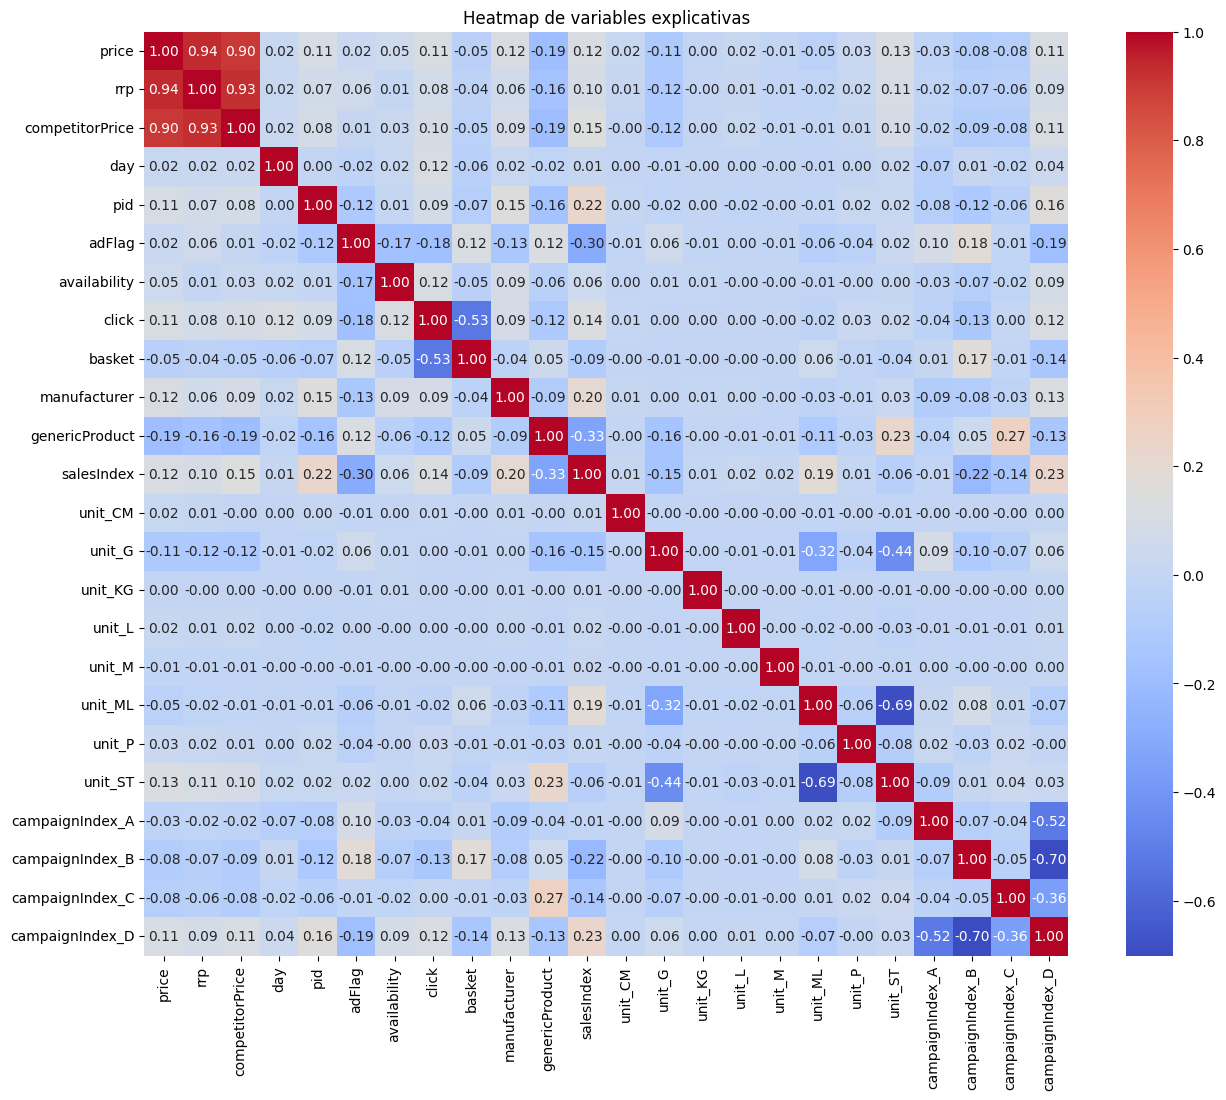

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Heatmap de variables explicativas')
plt.show()

En una inspección visual, observamos una elevada: correlación entre entre los precios, los precios de la competencia, precios de referencia, entre los distintos CampaignIndex.

Vamos a seleccionar las variables con un indice de correlación de más de 0.7 (valor absoluto)

In [ ]:
#generamos la lista donde vamos a guardar las variables
variables_correlacionadas = []

for i in range(len(matriz_correlaciones.columns)):
    for j in range(i+1, len(matriz_correlaciones.columns)):
        correlation = matriz_correlaciones.iloc[i, j]
        if abs(correlation) > 0.7:
            pares = matriz_correlaciones.columns[i] + ' - ' + matriz_correlaciones.columns[j]
            variables_correlacionadas.append((pares, correlation))

# Print the pairs with correlation coefficients
for pair, correlation in variables_correlacionadas:
    print(f"Variables: {pair}, Coeficiente de correlación: {correlation:.2f}")


Variables: price - rrp, Coeficiente de correlación: 0.94
Variables: price - competitorPrice, Coeficiente de correlación: 0.90
Variables: rrp - competitorPrice, Coeficiente de correlación: 0.93
Variables: campaignIndex_B - campaignIndex_D, Coeficiente de correlación: -0.70


Como puede verse, los precios están correlacionados con los precios de referencia y los precios de la competencia.

Con respecto a los Campaingindex, recordemos que se trata de una variable dummy que generamos a partir del tipo de campaña, la variable que nos dice si un producto es objeto de una campaña publicitaria es adFlag, que toma valores 0 y 1. Si adFlag=0 (no hay campaña), generamos la dummy campaignIndex_D.

Si bien el análisis previo nos indica que tenemos alta correlación entre las campañas B y D, vamos a eliminar todas nuestras variables campaignIndex, la variable adFlag es suficiente para captar el efecto de la publicidad en la probabilidad de ventas.

Finalmente, vamos a eliminar las dummies de 'unit', que indica la unidad del producto, y originalmente es un string de mayúsculas. Esto lo hacemos para simplificar el modelo y suponemos que las variables pid y manufacturer nos la información que necesitamos sobre como un producto determinado afecta las ventas.

In [ ]:
X = farmacia_re_escalada.drop([ 'lineID', 'order' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm' , 'revenue' ,

'rrp', 'competitorPrice', 'unit_CM', 'unit_G',  'unit_KG' , 'unit_L' , 'unit_M' , 'unit_P' , 'unit_ST', 'campaignIndex_A' , 'unit_ML',

 'campaignIndex_B' , 'campaignIndex_C' , 'campaignIndex_D' ], axis=1)

y = farmacia_re_escalada['order']

In [ ]:
#Constatamos que sólo nos quedamos con las variables que nos interesan

X.dtypes

price             float64
day                 int64
pid                 int64
adFlag              int64
availability        int64
click               int64
basket              int64
manufacturer        int64
genericProduct      int64
salesIndex          int64
dtype: object

##**Agrupamiento de productos**

Recordemos que tenemos 22 mil productos, identificados por valor numérico, pero no queremos que el valor numérico de un producto, que es puramente descriptivo, genere confusión en los resultados de nuestros modelos.

Vamos a generar dummies que nos indiquen si un producto es de precio 'bajo', 'medio', 'caro', el criterio es dividir el rango de precios en tercios y asignarlos a estas categorias

In [ ]:
#Constatamos que tenemos 22 mil productos en nuestro dataframe


productos=X['pid'].nunique()

print(productos)

21928


In [ ]:
X.dtypes

price             float64
day                 int64
pid                 int64
adFlag              int64
availability        int64
click               int64
basket              int64
manufacturer        int64
genericProduct      int64
salesIndex          int64
dtype: object

In [ ]:
#Dividimos el vector X de variables explicativas en tres cuantiles que se basan en los precios.

cuantiles = pd.qcut(X['price'], q=3, labels=['barato', 'medio', 'caro'])

dummies_cuantiles = pd.get_dummies(cuantiles)

# Lo concatenamos con X

nuevo_X = pd.concat([X, dummies_cuantiles], axis=1)



In [ ]:
nuevo_X

,price,day,pid,adFlag,availability,click,basket,manufacturer,genericProduct,salesIndex,barato,medio,caro
0,0.223145,1,6570,0,2,1,0,255,0,40,0,0,1
1,0.223145,2,6570,0,2,0,1,255,0,40,0,0,1
2,0.223145,2,6570,0,2,1,0,255,0,40,0,0,1
3,0.223145,4,6570,0,2,1,0,255,0,40,0,0,1
4,0.223145,5,6570,0,2,0,1,255,0,40,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,-0.582841,91,20700,0,2,0,0,753,0,52,1,0,0
2755999,-0.061666,91,12000,0,2,1,0,811,0,53,0,1,0
2756000,-0.805992,91,10485,0,2,1,0,61,0,52,1,0,0
2756001,-0.666523,91,15158,0,2,1,0,811,0,53,1,0,0


In [ ]:
#eliminamos la variable pid, product id, que ya no tiene sentido porque cada producto está agrupado por precio

X=nuevo_X.drop(['pid'], axis=1)

In [ ]:
#Constatamos que tenemos un vector X con las variables explicativas sin pid y con las nuevas dummies

X.dtypes

price             float64
day                 int64
adFlag              int64
availability        int64
click               int64
basket              int64
manufacturer        int64
genericProduct      int64
salesIndex          int64
barato              uint8
medio               uint8
caro                uint8
dtype: object

##**Agrupamiento por día de la semana**

La variable 'day' captura el día de la observación, y va de 1 a 91, porque tenemos 90 días de observaciones.

Como puede verse en el gráfico debajo, existe un alta estacionalidad en períodos de 7 días. Este es un hallazgo importante, cuando hablamos de estacionalidad, podríamos encontrar que se da a nivel de las semanas, o a nivel de meses, estaciones, etc. En cambio, el gráfico nos indica que la variabilidad temporal se dá al interior de cada semana.

Nuevamente, no queremos que el valor numérico de cada día afecte los resultados de un modelo, pero queremos retener la información ligada a la estacionalidad intra-semanal.

Entonces, vamos a suponer que el día 1 es "lunes" (no tenemos los días de la semana, solo un numero que indica los 90 días de observaciones), el día 2 es "martes", el día 8 vuelve a ser "lunes", y así hasta completar los 90 días

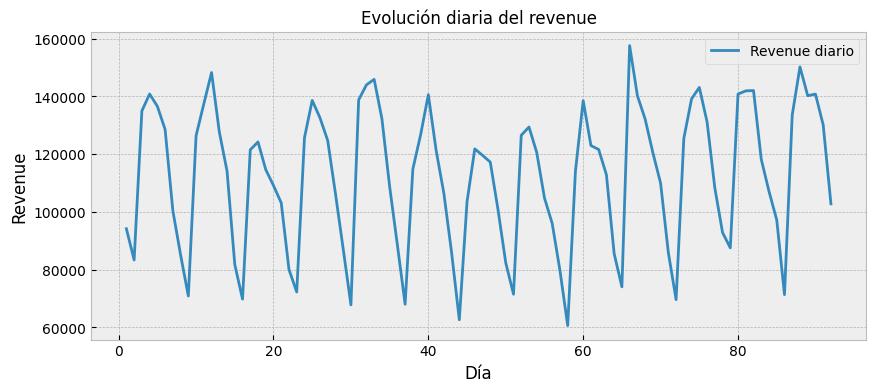

In [ ]:
revenue_diario = farmacia.groupby('day')['revenue'].sum() # Construimos una variable que sume el revenue diario.
mpl.style.use('bmh')
fig, ax = plt.subplots(figsize=(10 , 4))
ax.plot(revenue_diario, label ='Revenue diario') #pasamos la suma del revenue diario que construimos como variable a graficar
ax.set_title('Evolución diaria del revenue', fontsize='12')
ax.set_xlabel('Día', fontsize = '12')
ax.set_ylabel('Revenue', fontsize='12')
ax.legend(fontsize='10')
fig.show();

In [ ]:
#Creamos un diccionario de días de la semana

dias = {1: 'Lunes', 2: 'Martes', 3: 'Miercoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sabado', 7: 'Domingo'}

#Vinculamos el diccionario con la variable 'día' en el dataset, que tiene variables numéricas
X['dia_semana'] = X['day'].map(dias)

#Transformamos los días en dummy variables
dummies = pd.get_dummies(X['dia_semana'], prefix='dia')

#Agregamos las dummies a nuestro dataset original
X = pd.concat([X, dummies], axis=1)

#Eliminamos las columnas 'day' y 'dia_semana' que ya no nos son útiles
X = X.drop(['day', 'dia_semana'], axis=1)

In [ ]:
X

,price,adFlag,availability,click,basket,manufacturer,genericProduct,salesIndex,barato,medio,caro,dia_Domingo,dia_Jueves,dia_Lunes,dia_Martes,dia_Miercoles,dia_Sabado,dia_Viernes
0,0.223145,0,2,1,0,255,0,40,0,0,1,0,0,1,0,0,0,0
1,0.223145,0,2,0,1,255,0,40,0,0,1,0,0,0,1,0,0,0
2,0.223145,0,2,1,0,255,0,40,0,0,1,0,0,0,1,0,0,0
3,0.223145,0,2,1,0,255,0,40,0,0,1,0,1,0,0,0,0,0
4,0.223145,0,2,0,1,255,0,40,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,-0.582841,0,2,0,0,753,0,52,1,0,0,0,0,0,0,0,0,0
2755999,-0.061666,0,2,1,0,811,0,53,0,1,0,0,0,0,0,0,0,0
2756000,-0.805992,0,2,1,0,61,0,52,1,0,0,0,0,0,0,0,0,0
2756001,-0.666523,0,2,1,0,811,0,53,1,0,0,0,0,0,0,0,0,0


In [ ]:
X.dtypes

price             float64
adFlag              int64
availability        int64
click               int64
basket              int64
manufacturer        int64
genericProduct      int64
salesIndex          int64
barato              uint8
medio               uint8
caro                uint8
dia_Domingo         uint8
dia_Jueves          uint8
dia_Lunes           uint8
dia_Martes          uint8
dia_Miercoles       uint8
dia_Sabado          uint8
dia_Viernes         uint8
dtype: object

##**Diferencias con las variables seleccionadas por el algoritmo de Forward Selection**

Es interesante comparar con las variables que retuvimos despúes de realizar Forward Selection en la entrega previa:

>('price',
 'rrp',
 'competitorPrice',
 'day',
 'pid',
 'adFlag',
 'availability',
 'click',
 'basket',
 'manufacturer',
 'genericProduct')

 En lo que hace a las diferencias:

 > Eliminamos rrp y price, que son co-lineales con price

 > Sustituimos day por 3 ummies que las agrupan en función del nivel de precios.

 > Sustituimos 'day' por el día de la semana

 > Estamos reteniendo SalesIndex.



#**Regresion logistica**

En esta sección procedemos como hacemos habitualmente, dividiendo nuestro dataset, estimando el modelo y analizando diversas métricas para establecer la calidad del mismo.

In [ ]:
#Generamos los subsets de train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
#Estimamos la regresion
reg_logistica = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=0.001)

reg_logistica.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
y_pred = reg_logistica.predict(X_test) # dejamos que el modelo prediga los valores en el testing set.

##Medidas del modelo de regresión logística

###**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo:", f'{accuracy:.3f}')

Accuracy del modelo: 1.000


Hemos mantener un accuracy total en la predicción de la variable 'order'. Recordemos que con un mínimo de Feature Engineering en entregas previas habíamos obtenido un accuracy del 90%.

Esto indica que nuestra estructura de datos se adapta muy bien a la predicción de ventas (recordemos, variabe order, que toma el valor 1 cuando se trata de ventas y 0 cuando no), y, con algunos ajustes de Feature Engineering, logramos un modelo de muy alta potencia predictiva.

###**Matriz de confusión**

In [ ]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n\n", matriz_confusion)

Matriz de confusión:

 [[410309      0]
 [     0 140892]]


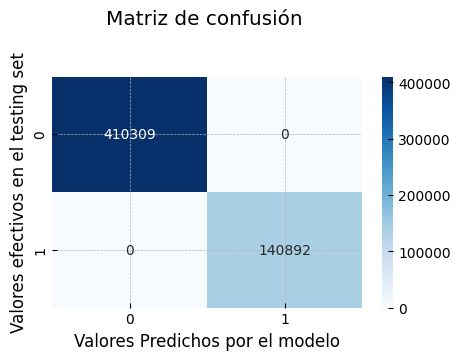

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Predichos por el modelo')
plt.ylabel('Valores efectivos en el testing set')
plt.title('Matriz de confusión \n\n ')
plt.show()

La matriz de confusión y su gráfico nos muestra que nuevamente logramos predecir correctamente la totalidad de las ventas (140.842, segunda columna) como las observaciones que no son ventas (410.309), todo lo cual es consistente con el accurady del 100% econtrado en el apartado anterior.

###**Coeficientes de la regresión y significatividad**

In [ ]:
#Buscamos los coeficientes de la regresión y sus p-values y -scores
coeficientes = reg_logistica.coef_[0]
z_scores = reg_logistica.coef_[0] / np.std(X_train, axis=0)
p_values = np.abs(reg_logistica.coef_[0]) / np.std(X_train, axis=0)

In [ ]:
#Armamos una tabla para mostrar los coeficientes y su significatividad

regresores = X.columns
resultados = pd.DataFrame({'Coeficientes': coeficientes, 'Z-Scores': z_scores, 'P-Value': p_values})

print("Coeficientes, z_scores, y p_values del modelo :\n\n", resultados)


Coeficientes, z_scores, y p_values del modelo :

                 Coeficientes   Z-Scores    P-Value
price               0.000000   0.000000   0.000000
adFlag              0.000000   0.000000   0.000000
availability        0.000000   0.000000   0.000000
click             -13.304794 -26.907987  26.907987
basket            -11.871211 -31.614450  31.614450
manufacturer       -0.000515  -0.000003   0.000003
genericProduct      0.000000   0.000000   0.000000
salesIndex          0.127235   0.019811   0.019811
barato              0.000000   0.000000   0.000000
medio               0.000000   0.000000   0.000000
caro                0.000000   0.000000   0.000000
dia_Domingo         0.000000   0.000000   0.000000
dia_Jueves          0.000000   0.000000   0.000000
dia_Lunes           0.000000   0.000000   0.000000
dia_Martes          0.000000   0.000000   0.000000
dia_Miercoles       0.000000   0.000000   0.000000
dia_Sabado          0.000000   0.000000   0.000000
dia_Viernes         0.000000   0

El análisis de los coeficientes nos indica que sólo click, basket, manufacturer y SalesIndex tienen algún efecto en order, lo cual habla de una cierta redundancia de los restantes regresores en esta especificación del modelo.

###**F1 Score**

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

1.0

Dado que logramos un accuracy del 100% con el modelo, es lógico que el precision score sea de 1, recordemos que la fórmula es:

Precisión= Verdadero Positivo / (Verdadero positivo + Falso Positivo)

En nuestro caso = 410309/(410309 + 0) = 1

###**Clasification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410309
           1       1.00      1.00      1.00    140892

    accuracy                           1.00    551201
   macro avg       1.00      1.00      1.00    551201
weighted avg       1.00      1.00      1.00    551201



La lectura del Classification Report nos indica que:

> 1. La precisión y el accuracy es del 100%
> 2. Dado que la precisión (accuracy) y el recall son 1, el F1 score también resulta en un valor de 1.

###**Curva AUC-ROC**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_score1 = reg_logistica.predict_proba(X_test)[:,1]
y_score1

array([0.99876765, 0.00140692, 0.99873878, ..., 0.0010694 , 0.0013398 ,
       0.0012964 ])

In [ ]:
# Calculo de tasas
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [ ]:
print('RoC - AUC Score: ', roc_auc_score(y_test, y_score1))

RoC - AUC Score:  1.0


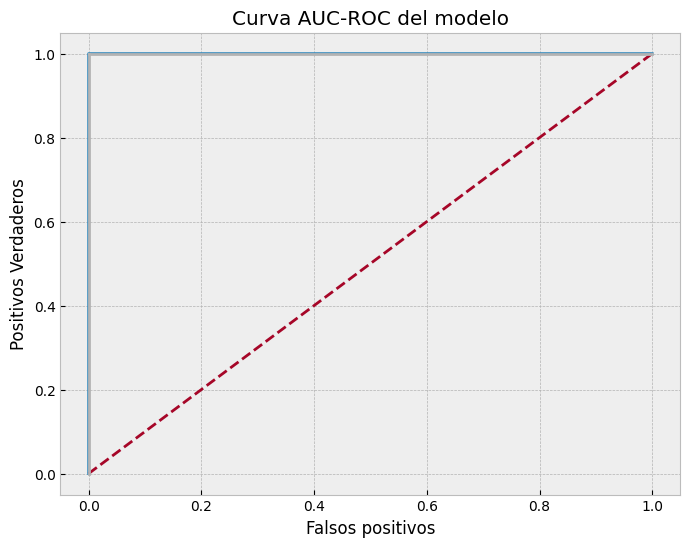

In [ ]:
plt.subplots(1, figsize=(8,6))
plt.title('Curva AUC-ROC del modelo')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Positivos Verdaderos')
plt.xlabel('Falsos positivos')
plt.show()

Dado el accuracy de 100% que alcanzamos con el modelo de regresión logística como se ha parametrizado, la curva AUC ROC nos muestra que el área debajo de la curva respecto a un modelo random es 'perfecto', ya que toca el valor de 1 en positivos verdaderos y no tiene falsos positivos.

#**PCA**

En una primera etapa, vamos a transformar nuestro dataset a través del PCA para ver como se distribuye la variación de los datos.

In [ ]:
from sklearn.decomposition import PCA


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
#Análisis de la varianza explicada para cada componente
variacion_explicada = pca.explained_variance_ratio_
variacion_explicada

array([9.98799794e-01, 1.12887587e-03, 3.32657539e-05, 9.82971062e-06,
       8.70908796e-06, 5.48349327e-06, 4.12700124e-06, 3.84622025e-06,
       2.32596027e-06, 2.13832043e-06, 2.72359334e-07, 2.59383008e-07,
       2.56068625e-07, 2.48381669e-07, 2.02752121e-07, 1.87710775e-07,
       1.78116086e-07, 1.37875871e-36])

Aunque es de difcíl lectura, el array de variación explicada nos indica que el 99.8% de la misma se explica por el primer componente, el 0.12% por el segundo, el 0.00003% por el tercer, componente, etc.

De momento transformemos el dataset usando todos los componentes. Más adelante trabajaremos con menos componentes.

In [ ]:
X_train

array([[-7.12944987e+01, -7.25528070e+00, -3.72866608e-01, ...,
        -5.17002479e-03, -6.55393959e-03,  5.00245192e-14],
       [-1.83859914e+01,  6.12641252e+00,  5.52736082e-01, ...,
        -1.03189819e-02, -1.27526783e-02, -3.08267922e-16],
       [-1.22382968e+02,  5.38401622e+00,  8.99128188e-01, ...,
        -4.84930154e-03, -6.35011425e-03, -1.06563579e-14],
       ...,
       [-1.55382694e+02,  5.15335269e+00, -1.33875976e-01, ...,
        -4.87410465e-03, -6.32506615e-03, -6.03947943e-17],
       [ 2.97689512e+02, -3.68681681e+00, -6.14954857e-01, ...,
        -4.80094546e-03, -6.21804626e-03,  1.05742491e-16],
       [-1.37381717e+02,  5.25765367e+00,  2.14626114e+00, ...,
        -4.37800674e-03, -6.01620590e-03,  1.55173193e-17]])

In [ ]:
#Ajustamos nuevamente una regresión logística usando los componentes del PCA

reg_logistica2 = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=0.001)

reg_logistica2.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
#Buscamos los coeficientes de la regresión y sus p-values y -scores
coeficientes2 = reg_logistica2.coef_[0]
z_scores2 = reg_logistica2.coef_[0] / np.std(X_train, axis=0)
p_values2 = np.abs(reg_logistica2.coef_[0]) / np.std(X_train, axis=0)

In [ ]:
#Armamos una tabla para mostrar los coeficientes y su significatividad

regresores = X.columns
resultados = pd.DataFrame({'Coeficientes': coeficientes2, 'Z-Scores': z_scores2, 'P-Value': p_values2})

print("Coeficientes, z_scores, y p_values del modelo PCA :\n\n", resultados)


Coeficientes, z_scores, y p_values del modelo PCA :

     Coeficientes   Z-Scores    P-Value
0      -0.002179  -0.000012   0.000012
1       0.059462   0.009449   0.009449
2      -0.308010  -0.285117   0.285117
3       1.372130   2.336587   2.336587
4       3.531805   6.389506   6.389506
5       0.000000   0.000000   0.000000
6       1.113218   2.925633   2.925633
7       0.000000   0.000000   0.000000
8     -16.902623 -59.171138  59.171138
9      -3.802702 -13.883946  13.883946
10      0.000000   0.000000   0.000000
11      0.000000   0.000000   0.000000
12      0.000000   0.000000   0.000000
13      0.000000   0.000000   0.000000
14      0.000000   0.000000   0.000000
15      0.000000   0.000000   0.000000
16      0.000000   0.000000   0.000000
17      0.000000   0.000000   0.000000


En este caso la lectura de los coeficientes ya no tiene una correspondencia directa con nuestras variables explicativas, sino con los componentes a los que redujimos el dataset.

In [ ]:
y_pred2 = reg_logistica2.predict(X_test) # dejamos que el modelo prediga los valores en el testing set.

In [ ]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy del modelo:", f'{accuracy:.3f}')

Accuracy del modelo: 1.000


In [ ]:
matriz_confusion2 = confusion_matrix(y_test, y_pred2)
print("Matriz de confusión PCA todos los componentes:\n\n", matriz_confusion)

Matriz de confusión PCA todos los componentes:

 [[410309      0]
 [     0 140892]]


Como puede verse con las medidas de accuracy y matriz de confusión, con la reducción de dimensionalidad encontramos el mismo nivel de efectividad del modelo que con el Feature Engineering previo.

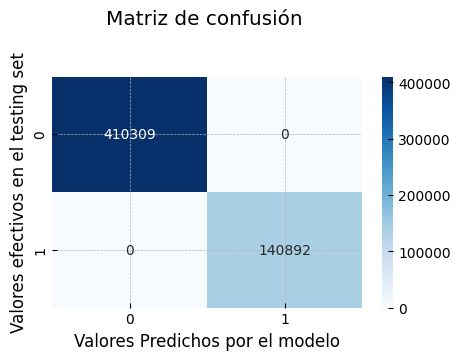

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Predichos por el modelo')
plt.ylabel('Valores efectivos en el testing set')
plt.title('Matriz de confusión \n\n ')
plt.show()

##**PCA con 1 componentes**

Como vimos, el 99.8% de la variación está explicado por el primer componente, en este apartado vamos a proponer un modelo de PCA con un componente, y volver a estimar el modelo logístico para entender si obtenemos los mismo resultados óptimos.

In [ ]:
# Volvemos a aplicar el PCA, esta vez con un solo componente.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pca2 = PCA(n_components=1)
X_train = pca2.fit_transform(X_train)
X_test = pca2.transform(X_test)

In [ ]:
#Análisis de la varianza explicada para cada componente
variacion_explicada = pca.explained_variance_ratio_
variacion_explicada

array([9.98799794e-01, 1.12887587e-03, 3.32657539e-05, 9.82971062e-06,
       8.70908796e-06, 5.48349327e-06, 4.12700124e-06, 3.84622025e-06,
       2.32596027e-06, 2.13832043e-06, 2.72359334e-07, 2.59383008e-07,
       2.56068625e-07, 2.48381669e-07, 2.02752121e-07, 1.87710775e-07,
       1.78116086e-07, 1.37875871e-36])

In [ ]:
reg_logistica3 = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=0.001)

reg_logistica3.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
y_pred3 = reg_logistica3.predict(X_test) # dejamos que el modelo prediga los valores en el testing set.

In [ ]:
accuracy = accuracy_score(y_test, y_pred3)
print(f"Accuracy del modelo:", f'{accuracy:.3f}')

Accuracy del modelo: 0.745


In [ ]:
matriz_confusion = confusion_matrix(y_test, y_pred3)
print("Matriz de confusión:\n\n", matriz_confusion)

Matriz de confusión:

 [[410449      0]
 [140752      0]]


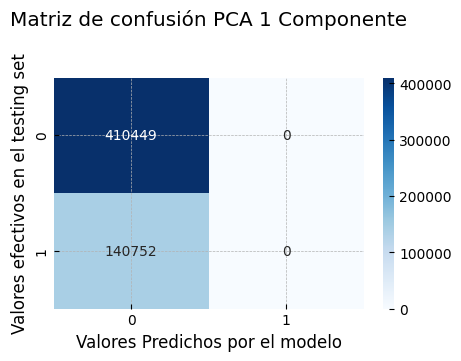

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Predichos por el modelo')
plt.ylabel('Valores efectivos en el testing set')
plt.title('Matriz de confusión PCA 1 Componente\n\n')
plt.show()

En este la regresión predice que la totalidad de las observaciones en el testing set son 0 (no-ventas), lo cual es notoriamente incorrecto, si bien un accuracy del 74.4% podría indicar que se trata de un modelo relativamente adecuado, es un resultado engañoso, lo que está sucediendo es que, en la práctica, cerca del 74% de las observaciones toman el valor de 0 en la variable order, el hecho de que el modelo prediga que todas las observaciones son 0 lleva a ese resultado, si se diera otra distribución entre ventas y no ventas en el dataset, nos encontraríamos con valores de accuracy y matriz de confusiones distintos, pero con el mismo patrón de errores.

